### Importings

In [244]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dabl
import missingno as msno
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster import hierarchy
import pickle
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, ttest_ind

%matplotlib inline

### Dataprep

In [245]:
path = '../Aula 68 - Machine Learning - Prof. Lucas Roberto/'

In [246]:
df_1 = pd.read_csv(path + 'CartaoCredito_cancelamento.csv')
df_0 = pd.read_csv(path + 'CartaoCredito_semtarget.csv')

In [247]:
df_0.shape, df_1.shape

((891, 14), (300, 14))

In [248]:
# adding target 
def add_target(df, target):
    df['target'] = target
    return df

In [249]:
df_1 = add_target(df_1, 1)
df_0 = add_target(df_0, 0)

In [250]:
df = pd.concat([df_0, df_1])
df.head()

,ID,PerfilEconomico,Sexo,Idade,PerfilCompra,ValorCompraAnual,GastoMax,GastoMedio,UF,CidadeResidencia,RegiaodoPais,NumeroComprasOnline,MesesDesempregado,Anuidade,target
0,1,3,homem,22,1,7250.0,517.857143,604.166667,MG,Morada Nova de Minas,Região Sudeste,54.924242,5,"62,9304011407",0
1,2,1,mulher,38,1,71283.0,5091.642857,5940.250000,RN,Marcelino Vieira,Região Nordeste,312.644737,7,"37,9153459043",0
2,3,3,mulher,26,0,7925.0,566.071429,660.416667,PR,Agudos do Sul,Região Sul,50.801282,6,"60,9993188527",0
3,4,1,mulher,35,1,531.0,37.928571,44.250000,PR,Congonhinhas,Região Sul,2.528571,7,"5,3944383134",0
4,5,3,homem,35,0,805.0,57.500000,67.083333,BA,Morpará,Região Nordeste,3.833333,0,"40,9964747337",0


In [251]:
df.shape

(1191, 15)

### Sanity check

In [252]:
# dropping id since there are duplicated ones
df.drop('ID', axis=1, inplace=True)

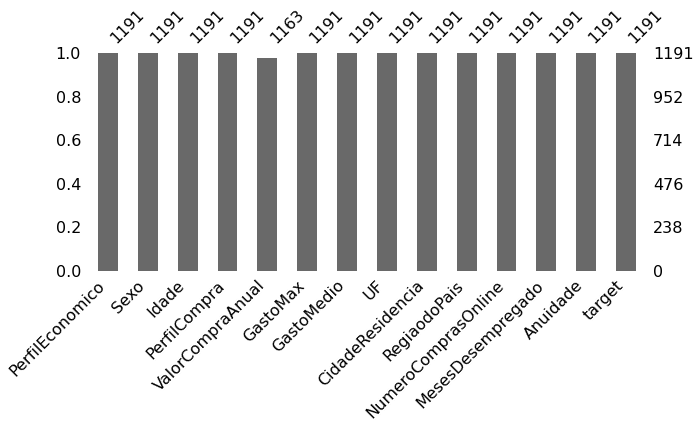

In [10]:
# verifying nulls
msno.bar(df, figsize=(10, 4))

In [253]:
df.dropna(inplace=True)

### EDA

C:\Users\milto\Anaconda3\lib\site-packages\dabl\preprocessing.py:418: UserWarning: Index not unique, resetting index!
  warn("Index not unique, resetting index!", UserWarning)
C:\Users\milto\Anaconda3\lib\site-packages\dabl\plot\utils.py:621: UserWarning: Dropped 4 outliers in column ValorCompraAnual.
  int(dropped), series.name), UserWarning)
C:\Users\milto\Anaconda3\lib\site-packages\dabl\plot\utils.py:621: UserWarning: Dropped 5 outliers in column GastoMedio.
  int(dropped), series.name), UserWarning)
C:\Users\milto\Anaconda3\lib\site-packages\dabl\plot\utils.py:621: UserWarning: Dropped 11 outliers in column NumeroComprasOnline.
  int(dropped), series.name), UserWarning)
C:\Users\milto\Anaconda3\lib\site-packages\dabl\plot\utils.py:621: UserWarning: Dropped 8 outliers in column PerfilCompra.
  int(dropped), series.name), UserWarning)


Target looks like classification
Linear Discriminant Analysis training set score: 0.613


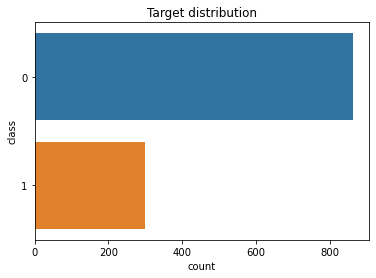

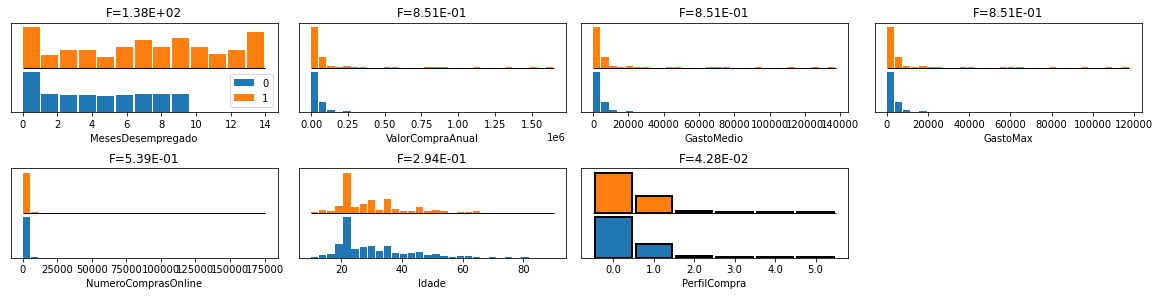

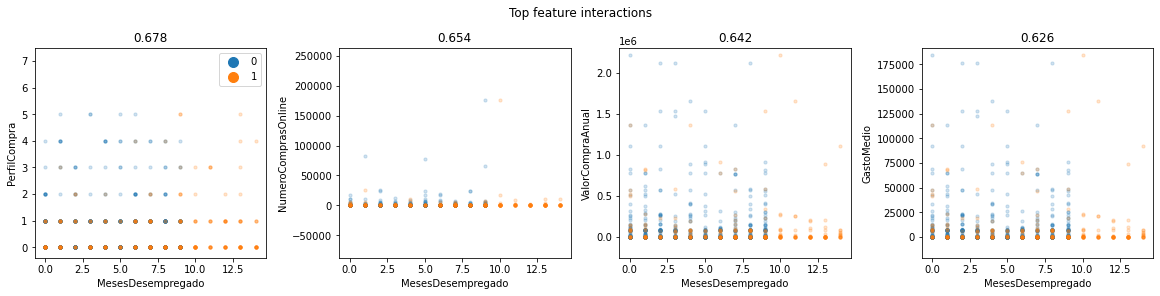

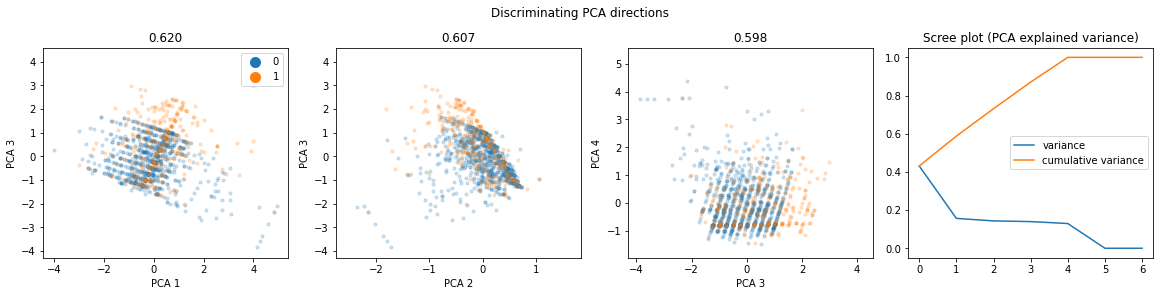

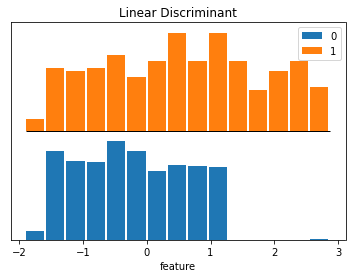

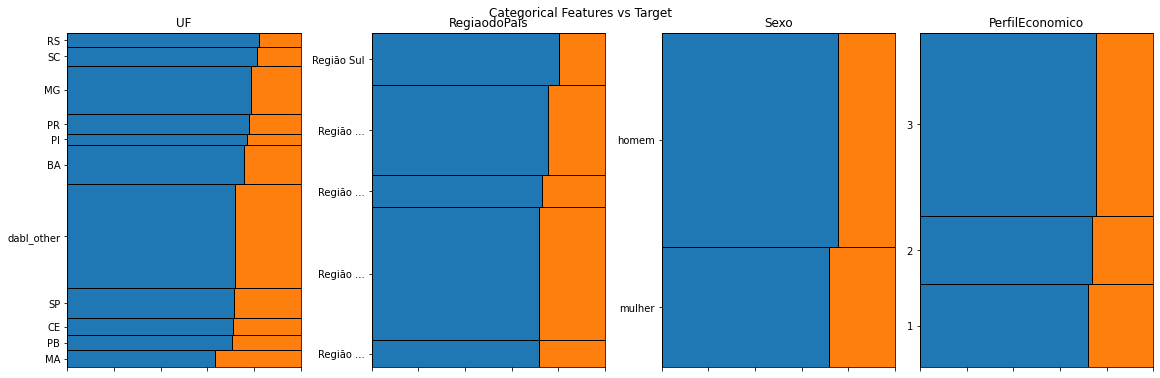

In [150]:
dabl.plot(df, target_col='target')

In [254]:
# replacing comma to dots
df['Anuidade'] = df['Anuidade'].str.replace(',', '.').astype(float)

In [255]:
df.reset_index(inplace=True, drop=True)

In [256]:
# normalizing data to better look at outliers
df_scaler = MinMaxScaler().fit_transform(df.select_dtypes(exclude='O'))

In [257]:
df_scaler = pd.DataFrame(df_scaler,
                         columns=df.select_dtypes(exclude='O').columns)

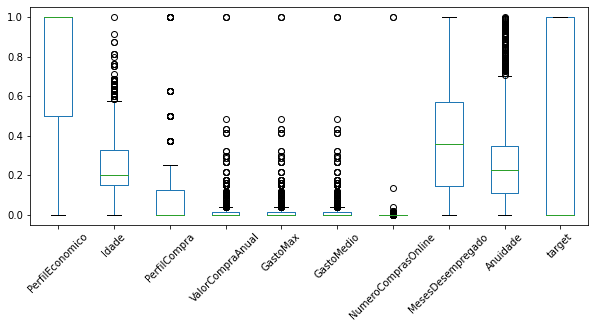

In [258]:
df_scaler.plot(kind='box', figsize=(10, 4), rot=45)

In [259]:
# deleting outliers by applying interquantile * 1.5

q_max_vca = ((df['ValorCompraAnual'].quantile(0.75) - df['ValorCompraAnual'].quantile(0.25)) * 1.5) + df['ValorCompraAnual'].quantile(0.75)
q_max_gmx = ((df['GastoMax'].quantile(0.75) - df['GastoMax'].quantile(0.25)) * 1.5) + df['GastoMax'].quantile(0.75)
q_max_gmd = ((df['GastoMedio'].quantile(0.75) - df['GastoMedio'].quantile(0.25)) * 1.5) + df['GastoMedio'].quantile(0.75)
q_max_nco = ((df['NumeroComprasOnline'].quantile(0.75) - df['NumeroComprasOnline'].quantile(0.25)) * 1.5) + df['NumeroComprasOnline'].quantile(0.75)

In [260]:
df_scaler.shape

(1163, 10)

In [261]:
df = df[(df['ValorCompraAnual'] < q_max_vca) &
        (df['GastoMax'] < q_max_gmx) &
        (df['GastoMedio'] < q_max_gmd) &
        (df['NumeroComprasOnline'] < q_max_nco)]

In [262]:
df.shape

(1000, 14)

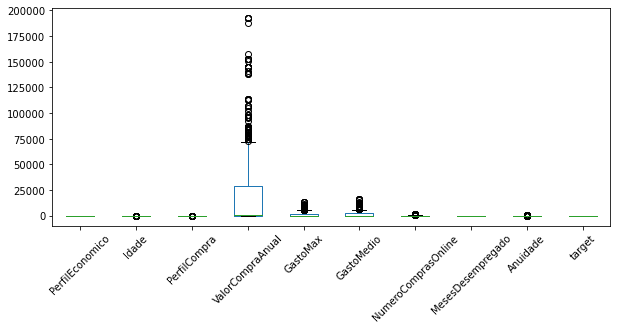

In [263]:
df.plot(kind='box', figsize=(10, 4), rot=45)

In [264]:
# transforming categorical values into onehot
df = pd.concat([df,
                pd.get_dummies(df[['Sexo', 'UF', 'RegiaodoPais']])],
                axis=1)

In [265]:
# getting rid of city column
df = df.select_dtypes(exclude='O')

### Modeling

In [266]:
x = df.drop('target', axis=1)
y = df['target']

In [267]:
models = {'lr': LogisticRegression(solver='liblinear'),
          'rf': RandomForestClassifier(),
          'knn': KNeighborsClassifier()}

scaler = MinMaxScaler()

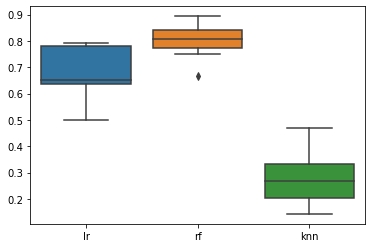

In [268]:
# crossvalidation to analyze which model perform better on f1-score

cv_score = []

for name, clf in models.items():
    pipe = Pipeline([('scaler', scaler),
                     (name, clf)])
    cv_score.append(cross_val_score(pipe, x, y, cv=10, scoring='f1'))
    
df_score = pd.DataFrame(cv_score, index=models.keys()).T
sns.boxplot(data=df_score)

In [270]:
# training random forest with rfecv to identify features to eliminate from the dataset
rfe = RFECV(RandomForestClassifier(random_state=42),
            scoring='f1', cv=10, verbose=2, n_jobs=-1)

In [271]:
rfe.fit(x, y)

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 fe

RFECV(cv=10,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='f1', step=1, verbose=2)

In [272]:
# selecting features chosen by rfe
x_feat = x.loc[:,rfe.get_support()]

In [274]:
# training the previous models with the selected feature

cv_score = []

for name, clf in models.items():
    pipe = Pipeline([('scaler', scaler),
                     (name, clf)])
    cv_score.append(cross_val_score(pipe, x_feat, y, cv=10, scoring='f1'))
    
df_score_feat = pd.DataFrame(cv_score, index=models.keys()).T

In [275]:
df_score_feat.columns = [col + '_feat' for col in df_score_feat.columns]

In [276]:
df_score_feat = pd.concat([df_score, df_score_feat], axis=1)

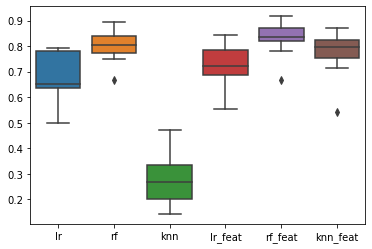

In [277]:
# comparing the performance of the models with the feature selection
sns.boxplot(data=df_score_feat)

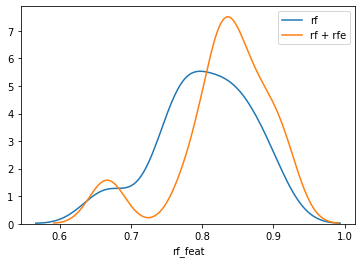

In [279]:
# comparing the random forests with all the features and with feature selection
sns.distplot(df_score_feat['rf'], hist=False, label='rf')
sns.distplot(df_score_feat['rf_feat'], hist=False, label='rf + rfe')

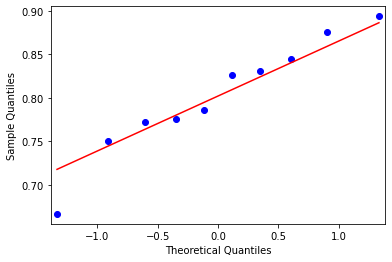

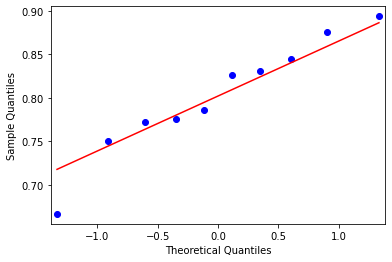

In [280]:
# analyze qqplot to visualize whether the score follows a normal distribution
qqplot(df_score_feat['rf'], line='s')

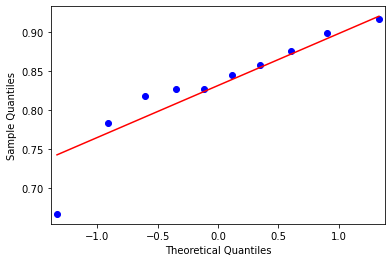

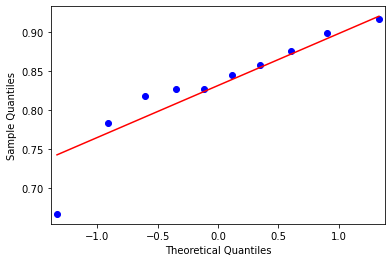

In [281]:
qqplot(df_score_feat['rf_feat'], line='s')

In [282]:
# shapiro-wilk test to estimate whether rf follows a normal distribution
stat, p = shapiro(df_score_feat['rf'])

In [283]:
print(f'Shapiro-Wilk: {round(stat, 3)} and p-value {round(p, 3)}')
print('P-value is above 0.05 and sample looks like Gaussian')

Shapiro-Wilk: 0.957 and p-value 0.752
P-value is above 0.05 and sample looks like Gaussian


In [284]:
stat, p = shapiro(df_score_feat['rf_feat'])
print(f'Shapiro-Wilk: {round(stat, 3)} and p-value {round(p, 3)}')
print('P-value is above 0.05 and sample looks like Gaussian')

Shapiro-Wilk: 0.888 and p-value 0.162
P-value is above 0.05 and sample looks like Gaussian


In [285]:
ttest, p = ttest_ind(df_score_feat['rf'], df_score_feat['rf_feat'])

In [286]:
# t-test to analyze whether the rf and rf + feat are distinctive
print(f'T-test: {round(ttest, 3)} and p-value {round(p, 3)}')
print('P-value is above 0.05 and we can not reject the null hypothesis')

# we can not assume that they provide distinctive scores, but I will continue with 
# rfe feature selection since it decreases the time of processing and still give similar results

T-test: -0.953 and p-value 0.353
P-value is above 0.05 and we can not reject the null hypothesis


In [289]:
x_train, x_test, y_train, y_test = train_test_split(x_feat, y, random_state=42)

In [290]:
param_grid = {'max_depth': np.arange(3, 20),
              'n_estimators': [100, 200, 500],
              'min_samples_leaf': [1, 5, 10]}

In [291]:
# grid search on random forest
grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, scoring='f1',
                    n_jobs=-1, cv=10, verbose=10)

In [292]:
grid.fit(x_train, y_train)

Fitting 10 folds for each of 153 candidates, totalling 1530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                 

In [293]:
# showing best params
print(grid.best_params_)

{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 100}


In [294]:
y_pred = grid.predict(x_test)

In [296]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       186
           1       1.00      0.75      0.86        64

    accuracy                           0.94       250
   macro avg       0.96      0.88      0.91       250
weighted avg       0.94      0.94      0.93       250



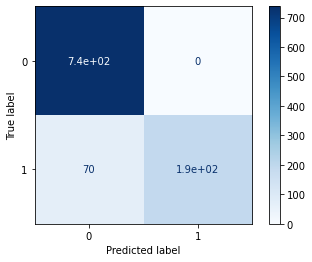

In [297]:
plot_confusion_matrix(grid.best_estimator_, x_feat, y, values_format='.2g', cmap=plt.cm.Blues)

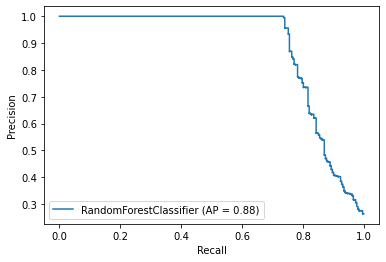

In [298]:
plot_precision_recall_curve(grid.best_estimator_, x_feat, y)

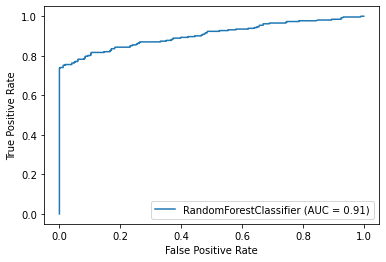

In [299]:
plot_roc_curve(grid.best_estimator_, x_feat, y)

In [300]:
df_rf_feat_imp = pd.DataFrame(grid.best_estimator_.feature_importances_.T,
                              index=x_feat.columns, columns=['feat']).sort_values('feat')

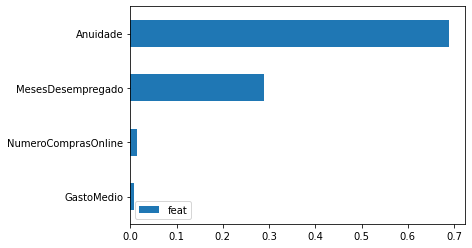

In [302]:
# providing the importance of each feature
df_rf_feat_imp.plot.barh()

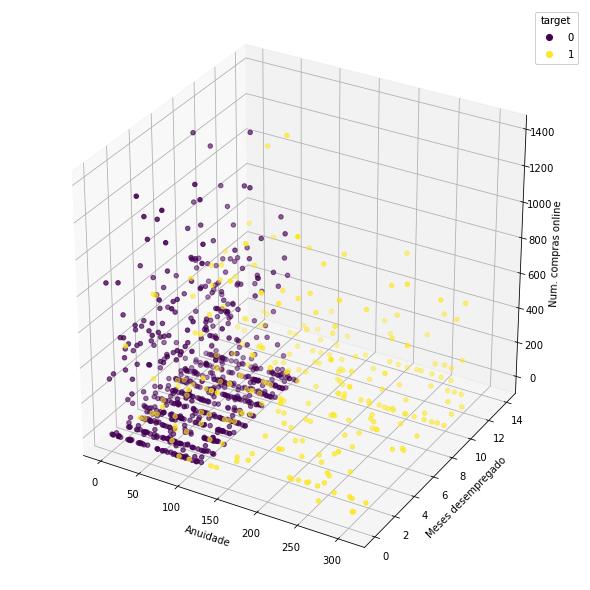

In [303]:
# looking at the top 3 features on a 3d plot
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)

scatter = ax.scatter(x_feat['Anuidade'],
           x_feat['MesesDesempregado'],
           x_feat['NumeroComprasOnline'], c=y)

ax.set_xlabel('Anuidade')
ax.set_ylabel('Meses desempregado')
ax.set_zlabel('Num. compras online')


legend1 = ax.legend(*scatter.legend_elements(), title="target")
ax.add_artist(legend1)


plt.show()

In [ ]:
# saving best model into pickle file
filename = 'random_forest_gridsearch.pkl'
pickle.dump(grid.best_estimator_, open(filename, 'wb'))

### Clustering

In [304]:
x_0 = df[df['target'] == 0].drop('target', axis=1)
x_1 = df[df['target'] == 1].drop('target', axis=1)

In [305]:
# since our dataset is not that big, I'll apply hierarchical clustering to analyze clusters for each group
# starting for the group that didn't cancel the service
z_0 = hierarchy.linkage(x_0, 'ward')

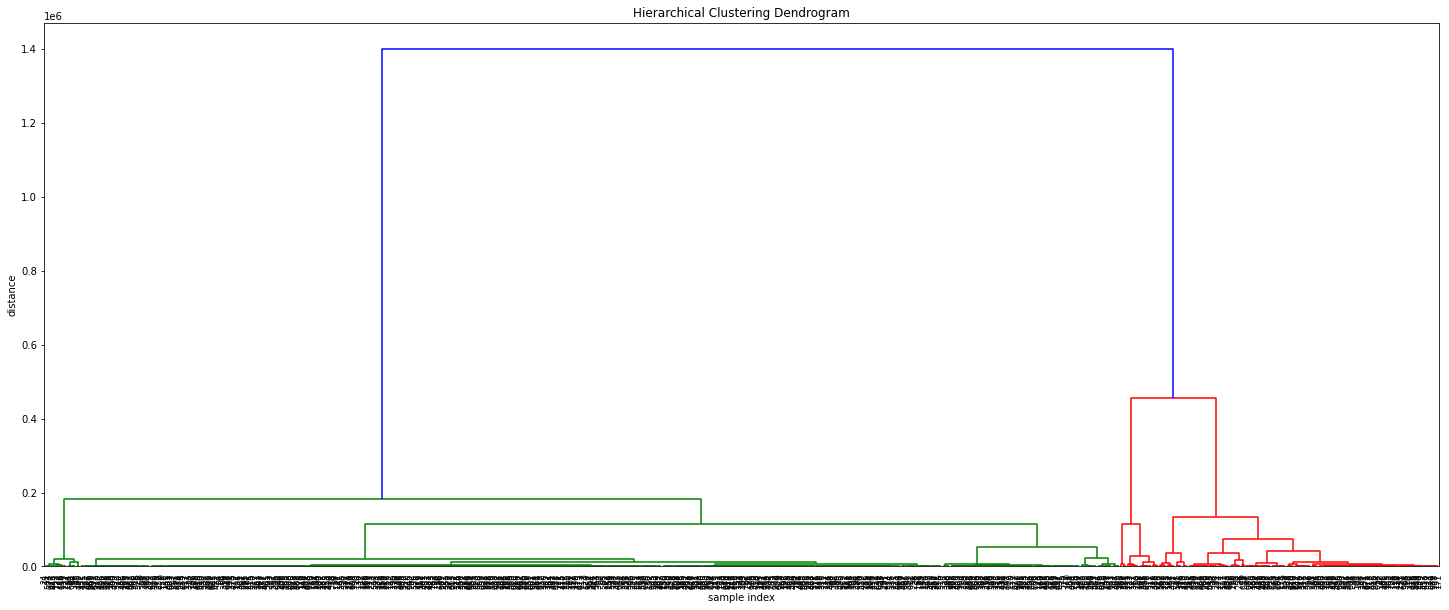

In [306]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(z_0,
                     leaf_rotation=90.,  # rotates the x axis labels
                     leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

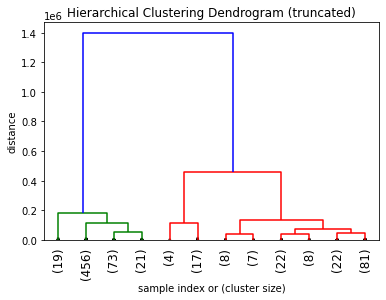

In [308]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    z_0,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [309]:
# clustering the group that cancel the group
z_1 = hierarchy.linkage(x_1, 'ward')

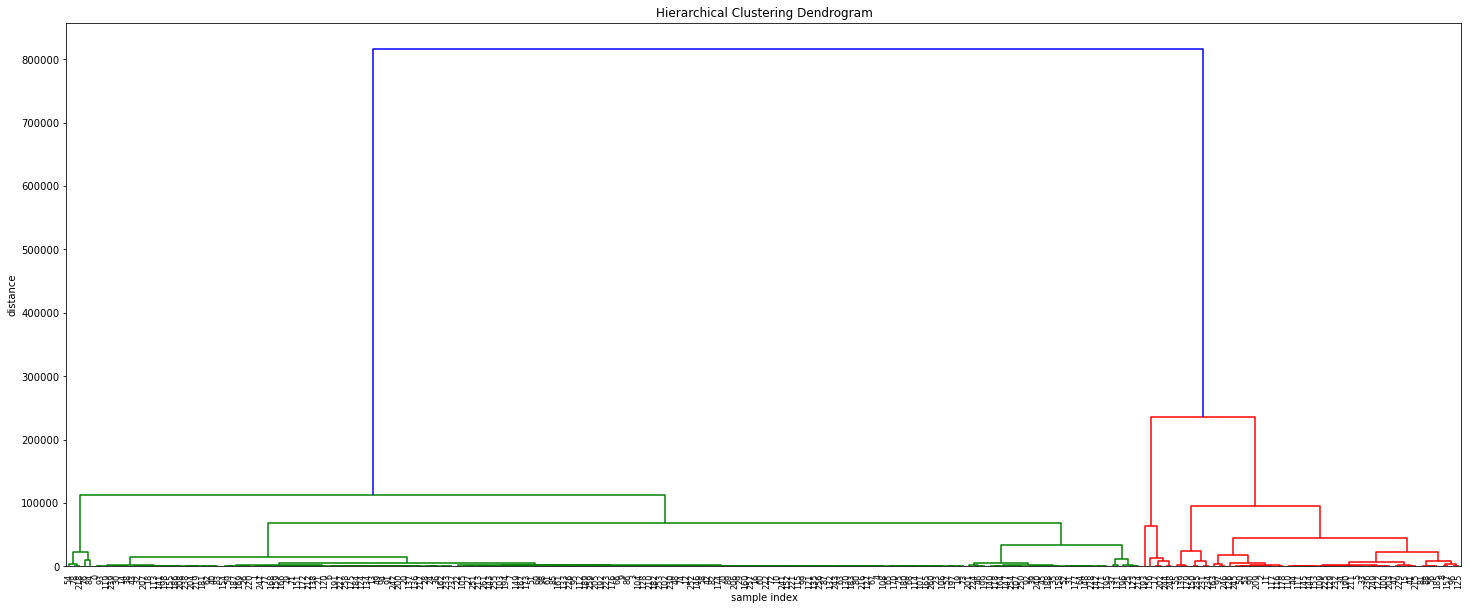

In [310]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(z_1,
                     leaf_rotation=90.,  # rotates the x axis labels
                     leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

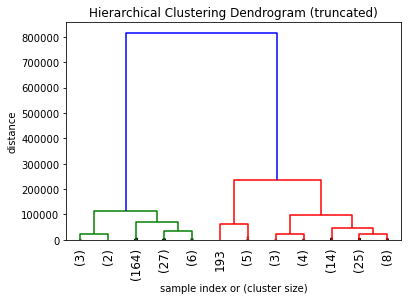

In [312]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    z_1,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()